  Age Group  Year Period  Unemployment_Rate
0     16-19  2024    M09               14.3
1     16-19  2024    M08               14.1
2     16-19  2024    M07               12.4
3     16-19  2024    M06               12.1
4     16-19  2024    M05               12.3
Columns in dataframe: ['Age Group', 'Year', 'Period', 'Unemployment_Rate', 'Month', 'Date']
First few rows of Month column: 0    9
1    8
2    7
3    6
4    5
Name: Month, dtype: int64

Annual Hiring Gap Analysis:
--------------------------------------------------------------------------------
Year    Target    Feasible    Gap    Gap Rate
--------------------------------------------------------------------------------


/Users/kylewu/Library/Mobile Documents/com~apple~CloudDocs/Software_Projects/info_5900/findings/../calculator/feasible_to_hire_calculator.py:125: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=121, freq='M')[1:]
/Users/kylewu/Library/Mobile Documents/com~apple~CloudDocs/Software_Projects/info_5900/findings/../calculator/feasible_to_hire_calculator.py:125: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=121, freq='M')[1:]
/Users/kylewu/Library/Mobile Documents/com~apple~CloudDocs/Software_Projects/info_5900/findings/../calculator/feasible_to_hire_calculator.py:125: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=121, freq='M')[1:]
/Users/kylewu/Library/Mobile Documents/c

ValueError: Unknown format code 'd' for object of type 'float'

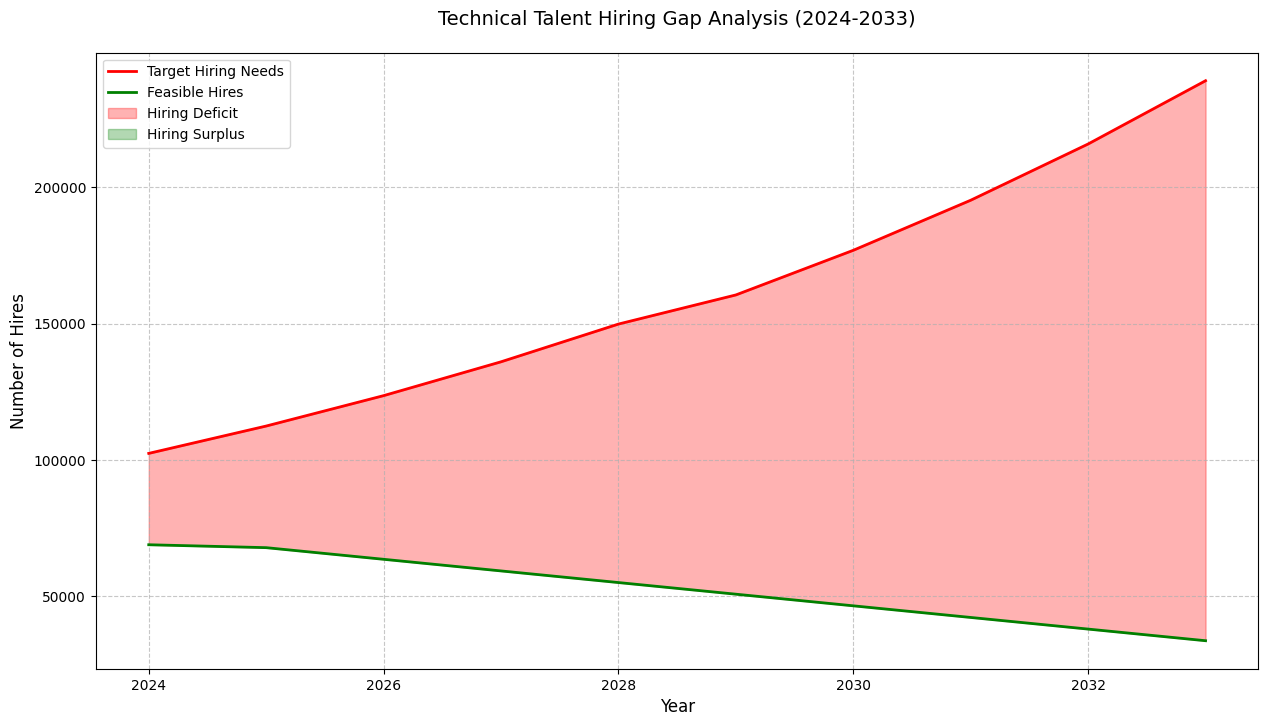

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from calculator.total_hire_target_calculator import calculate_projections, get_annual_hiring_needs
from calculator.feasible_to_hire_calculator import predict_unemployment_rates, get_feasible_hires_by_year
from calculator.feasible_to_hire_calculator import channel_population, hiring_channels, age_group_mapping

# Get historical unemployment data
historical_data = pd.read_csv('../data/bls_unemployment_by_age_group.csv')
predictions_by_age = predict_unemployment_rates(historical_data)

# Calculate projections and get hiring needs
df = calculate_projections()
hiring_needs = get_annual_hiring_needs(df)

feasible_hires = get_feasible_hires_by_year(
    channel_population, 
    hiring_channels, 
    predictions_by_age, 
    age_group_mapping
)

# Calculate hiring gap
hiring_gap = pd.DataFrame(index=range(2024, 2034))
hiring_gap['Target_Hires'] = hiring_needs['Total_Hires'].values  # Changed from 'Total_Hires' column
hiring_gap['Feasible_Hires'] = feasible_hires['Feasible_Hires'].astype(float)
hiring_gap['Gap'] = hiring_gap['Feasible_Hires'] - hiring_gap['Target_Hires']
hiring_gap['Gap_Percentage'] = (hiring_gap['Gap'] / hiring_gap['Target_Hires']) * 100

# Create visualization
plt.figure(figsize=(15, 8))
plt.plot(hiring_gap.index, hiring_gap['Target_Hires'].values, 'r-', 
         label='Target Hiring Needs', linewidth=2)
plt.plot(hiring_gap.index, hiring_gap['Feasible_Hires'].values, 'g-', 
         label='Feasible Hires', linewidth=2)
plt.fill_between(hiring_gap.index, 
                hiring_gap['Target_Hires'].values, 
                hiring_gap['Feasible_Hires'].values,
                where=(hiring_gap['Gap'].values < 0),
                color='red', alpha=0.3, label='Hiring Deficit')
plt.fill_between(hiring_gap.index,
                hiring_gap['Target_Hires'].values,
                hiring_gap['Feasible_Hires'].values,
                where=(hiring_gap['Gap'].values >= 0),
                color='green', alpha=0.3, label='Hiring Surplus')

plt.title('Technical Talent Hiring Gap Analysis (2024-2033)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Hires', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Print detailed results
print("\nAnnual Hiring Gap Analysis:")
print("-" * 80)
print("Year    Target    Feasible    Gap    Gap Rate")
print("-" * 80)
for year in hiring_gap.index:
    target = hiring_gap.loc[year, 'Target_Hires']
    feasible = hiring_gap.loc[year, 'Feasible_Hires']
    gap = hiring_gap.loc[year, 'Gap']
    gap_rate = hiring_gap.loc[year, 'Gap_Percentage']
    
    print(f"{year}  {target:>8,d}  {feasible:>10,d}  {gap:>6,d}  {gap_rate:>7.1f}%")

# Output key findings
print("\nKey Findings:")
print("-" * 80)
print(f"1. Average Annual Gap: {hiring_gap['Gap'].mean():,.0f} people")
print(f"2. Largest Gap Year: {hiring_gap['Gap'].idxmin()}, Gap: {hiring_gap['Gap'].min():,.0f} people")
print(f"3. Cumulative 10-Year Gap: {hiring_gap['Gap'].sum():,.0f} people")
print(f"4. Number of Years with Deficit: {(hiring_gap['Gap'] < 0).sum():,f} years")

# ... existing code ...

# Calculate the total deficit that needs to be addressed
total_deficit = abs(hiring_gap.loc[hiring_gap['Gap'] < 0, 'Gap'].sum())
print(f"\nTotal Deficit to Address: {total_deficit:,.0f} people")

plt.show()

# Save results to CSV
hiring_gap.to_csv('hiring_gap_analysis.csv')